# Outlier identification

## Passive aggressive classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

In [2]:
n=200
inliers_v = int(n * 0.95)
outliers_v = n - inliers_v

In [3]:
X_inliers = 0.3 * np.random.randn(inliers_v, 1)

X_outliers = np.random.uniform(low=-4, high=4, size=(outliers_v, 1))
X = np.r_[X_inliers, X_outliers]
X =X.flatten()
X = np.abs(X)
X = X[np.random.permutation(len(X))]

In [4]:
# Example DataFrame
data = {'time': pd.date_range(start='2024-01-01', periods=n, freq='D'),
        'cvr': X }  # Simulated CVR data
df = pd.DataFrame(data)

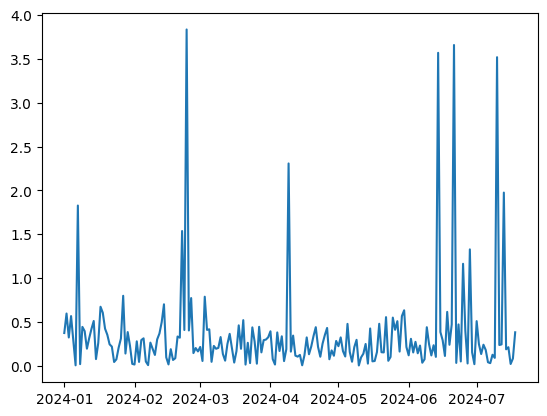

In [5]:
plt.plot(df['time'], df['cvr'])

In [6]:
# Define thresholds (e.g., 1.5 IQR rule)
q1 = df['cvr'].quantile(0.25)
q3 = df['cvr'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(lower_bound, upper_bound)


# Label data
df['outlier'] = np.where((df['cvr'] < lower_bound) | (df['cvr'] > upper_bound), 1, 0)
df.tail()

-0.29366728495103855 0.7978628204636177


,time,cvr,outlier
195,2024-07-14,0.189775,0
196,2024-07-15,0.213443,0
197,2024-07-16,0.022470,0
198,2024-07-17,0.085185,0
199,2024-07-18,0.383529,0


In [7]:
df['outlier'].value_counts()

outlier
0    189
1     11
Name: count, dtype: int64

## Scaling data

In [8]:
scaler = StandardScaler()
df['cvr_scaled'] = scaler.fit_transform(df[['cvr']])

In [9]:
X = df[['cvr_scaled']]
y = df['outlier']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Implementing passive aggressive classifier

In [10]:
pac = PassiveAggressiveClassifier(random_state=42)
pac.fit(X_train, y_train)

PassiveAggressiveClassifier(random_state=42)

## Predicting values

In [11]:
y_pred = pac.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])

In [12]:
y_test.values

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0])

## Calculating metrics

In [13]:
# Model evaluation
print(f"Test Set Accuracy : {accuracy_score(y_test, y_pred) * 100} %\n\n")  

print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, pac.decision_function(X_test)))

Test Set Accuracy : 100.0 %


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00         6

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

ROC-AUC Score: 1.0


## Real time prediction

In [14]:
# Simulate streaming data
new_data = {'cvr': [0.02, 1.2, 0.03]}
new_df = pd.DataFrame(new_data)
new_df['cvr_scaled'] = scaler.transform(new_df[['cvr']])

# Update model
pac.partial_fit(new_df[['cvr_scaled']], [0, 1, 0])  # Assuming labels for new data

PassiveAggressiveClassifier(random_state=42)

In [15]:
predictions = pac.predict(new_df[['cvr_scaled']])
print("Real-Time Predictions:", predictions)

Real-Time Predictions: [0 1 0]


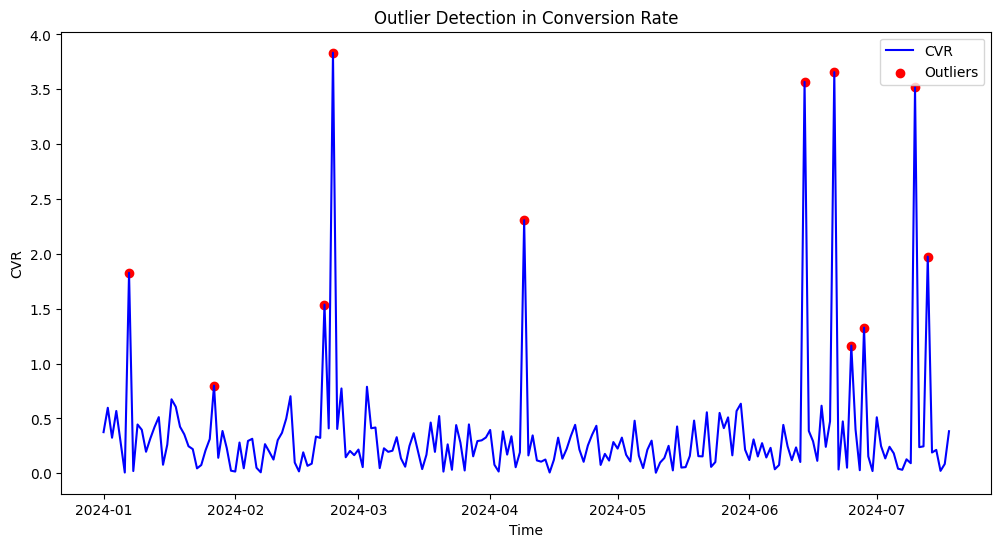

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['cvr'], label='CVR', color='blue')
plt.scatter(df['time'][df['outlier'] == 1], df['cvr'][df['outlier'] == 1], 
            color='red', label='Outliers')
plt.xlabel('Time')
plt.ylabel('CVR')
plt.title('Outlier Detection in Conversion Rate')
plt.legend()
plt.show()

## Creating pipeline

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [18]:
X = df[['cvr']]
y = df['outlier']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [19]:
# # Define ColumnTransformer to explicitly manage feature transformations
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('scaler', StandardScaler(), ['cvr'])  # Apply StandardScaler to 'cvr'
#     ]
# )

In [20]:
# # Define the pipeline
# pipeline = Pipeline([
#     ('preprocessor', preprocessor),  # Step 1: Normalize the data
#     ('classifier', PassiveAggressiveClassifier(random_state=42))  # Step 2: Classifier
# ])

In [21]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Normalize the data
    ('classifier', PassiveAggressiveClassifier(random_state=42))  # Step 2: Classifier
])

In [22]:
X_train

,cvr
0,0.375233
1,0.597354
2,0.324513
3,0.568194
4,0.289867
...,...
155,0.274893
156,0.144398
157,0.232337
158,0.036876


In [23]:
# Train the pipeline
pipeline.fit(X_train, y_train)

# Predict on test data
y_pred = pipeline.predict(X_test)

# Evaluate the pipeline
print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, pipeline.decision_function(X_test))
print("ROC-AUC Score:", roc_auc)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00         6

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

ROC-AUC Score: 1.0


## Predicting new values

In [24]:
# Simulated new data
new_data = pd.DataFrame({'cvr': [0.02, 0.92, 0.08, 1.5]})
new_data

,cvr
0,0.02
1,0.92
2,0.08
3,1.50


In [25]:
new_predictions = pipeline.predict(new_data)
new_predictions

array([0, 0, 0, 1])

In [26]:
# Predict outliers
new_predictions = pipeline.predict(new_data)
new_decision_scores = pipeline.decision_function(new_data)

# Display results
new_data['outlier'] = new_predictions
new_data['decision_score'] = new_decision_scores
display(new_data)


,cvr,outlier,decision_score
0,0.02,0,-6.739905
1,0.92,0,-0.917198
2,0.08,0,-6.351725
3,1.50,1,2.835213
